In [1]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import warnings
warnings.filterwarnings('ignore')

In [2]:
#港口坐标数据
#港口坐标数据描述每个运单在船运的过程中涉及的港口位置信息。
port=pd.read_csv('../event_port/port.csv')

In [3]:
#gpsdf.shape
#gpsdf.to_csv('gps_sample5kw.csv',index=False)
gpsdf_raw=pd.read_csv('筛选的训练data.csv')

In [4]:
#对数据进行预处理
def get_data(data, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    if mode=='train':#船舶将要到达的下一个港口的预计时间,转码格式
        pass
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']#当前时间
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)#离开起运港时间
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)

    return data
gpsdf = get_data(gpsdf_raw, mode='train')
print('finished.........')

finished.........


In [5]:
grouped=gpsdf.groupby('loadingOrder')
cnt_len=[]
cut_name=[]
for name,group in grouped:
    if len(group)<100:
        cut_name.append(name)
gpsdf=gpsdf[~gpsdf['loadingOrder'].isin(cut_name)]
gpsdf=gpsdf.reset_index(drop=True)
print('finished.........')

finished.........


In [6]:
#清洗训练数据(针对标签的清洗，因为有很多运单中间大量停船过程)
grouped=gpsdf.groupby('loadingOrder')
cnt_maxtime=[]
reserve_name=[]
for name,group in grouped:
    group=group.reset_index(drop=True)
    time_dif=group['timestamp'].diff(1).dt.total_seconds()//3600#小时为单位
    time_dif=time_dif.values[1:]
    if len(time_dif)<50:
        reserve_name.append(name)
        continue
    cnt_maxtime.append(np.max(time_dif))
    if np.max(time_dif)<10:#跳跃小于10个小时的用于训练
        reserve_name.append(name)
    #break
gpsdf=gpsdf[gpsdf['loadingOrder'].isin(reserve_name)]
gpsdf=gpsdf.reset_index(drop=True)

In [61]:
import time
import random
from geopy.distance import geodesic
#
def cut_zero_end(data):
    for i in range(len(data)-1,0,-1):
        if data[i]!=0:
            break
    return i+1
def cut_zero_start(data):
    for i in range(len(data)):
        if data[i]!=0:
            break
    return i-1
#
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度
def cal_turn_dis(portNames):
    xx=[]
    yy=[]
    dis=0
    lon_dis=0
    lat_dis=0
    dis_sqrt=0
    for name in portNames:
        xx.append(convert_name_xy(name)[0])
        yy.append(convert_name_xy(name)[1])
    for i in range(1,len(xx)):
        dis+=geodesic((yy[i-1],xx[i-1]), (yy[i],xx[i])).km
        lon_dis+=abs(xx[i]-xx[i-1])
        lat_dis+=abs(yy[i]-yy[i-1])
        dis_sqrt+=np.sqrt(abs(xx[i]-xx[i-1])**2+abs(yy[i]-yy[i-1])**2)
    return dis,lon_dis,lat_dis,dis_sqrt
    
def get_train_feature(df,bottom,top):
    #
    data=list(df['speed'])
    length=len(df)
    cut_start=int(length*bottom)
    cut_end=int(length*top)
    df=df[cut_start:cut_end].reset_index(drop=True)
    if len(df)<10:
        return [0 for i in range(38)]
    feature=[]
    length=len(df)
    sx=df['longitude'][0]
    sy=df['latitude'][0]
    ex=df['longitude'][length-1]
    ey=df['latitude'][length-1]
    
    dis=geodesic((sy,sx), (ey,ex)).km
    lon_dis=abs(ex-sx)
    lat_dis=abs(ey-sy)
    dis_sqrt=np.sqrt(lon_dis*lon_dis+lat_dis*lat_dis)
     
    label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    #下面开始截断
    cut_ratio=0.5
    df=df[:int(length*cut_ratio)]
    
    length=len(df)
    dsx=df['longitude'][0]
    dsy=df['latitude'][0]
    dex=df['longitude'][length-1]
    dey=df['latitude'][length-1]
    cal_dis=geodesic((dsy,dsx), (dey,dex)).km#截取出来的一段距离
    cut_label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    
    cal_speed=cal_dis/(cut_label+0.1)
    df['lat_diff']=df['latitude'].diff(1)
    df['lon_diff']=df['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    #
    df['speed_diff'] = df['speed'].diff(1)#速度变化量
    df['diff_minutes'] =df['timestamp'].diff(1).dt.total_seconds() / 60#记录之间的间隔时间(单位:s)
    #
    k_1_4=df['k'].quantile(0.25)
    k_median=df['k'].quantile(0.5)
    k_3_4=df['k'].quantile(0.75)
    #在所有的记录中，多少记录是停船状态
    #df['anchor'] = ((df['lat_diff'] <= 0.03) & (df['lon_diff'] <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] <= 10)).astype(int)
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 10)).astype(int)

    anchor_cnt = df['anchor'].sum()
    anchor_ratio = anchor_cnt / len(df)
    #
    lat_1_4=df['latitude'].quantile(0.25)
    lat_3_4=df['latitude'].quantile(0.75)
    lat_min=df['latitude'].min()
    lat_max=df['latitude'].max()
    lat_mean=df['latitude'].mean()
    lat_median=df['latitude'].median()
    #
    lon_1_4=df['longitude'].quantile(0.25)
    lon_3_4=df['longitude'].quantile(0.75)
    longitude_1_4=df['longitude'].quantile(0.25)
    longitude_3_4=df['longitude'].quantile(0.75)
    lon_min=df['longitude'].min()
    lon_max=df['longitude'].max()
    lon_mean=df['longitude'].mean()
    lon_median=df['longitude'].median()
    #
    speed_1_4=df['speed'].quantile(0.25)
    speed_3_4=df['speed'].quantile(0.75)
    speed_max=df['speed'].max()
    speed_mean=df['speed'].mean()
    speed_median=df['speed'].median()
    #
    direction_1_4=df['direction'].quantile(0.25)
    direction_3_4=df['direction'].quantile(0.75)
    direction_min=df['direction'].min()
    direction_max=df['direction'].max()
    direction_mean=df['direction'].mean()
    direction_median=df['direction'].median()
    #
    feature.append(k_1_4)
    feature.append(k_3_4)
    feature.append(k_median)
    feature.append(anchor_cnt)
    feature.append(anchor_ratio)
    #
    feature.append(lat_1_4)
    feature.append(lat_3_4)
    feature.append(lat_max)
    feature.append(lat_min)
    feature.append(lat_median)
    feature.append(lat_mean)
    #
    feature.append(lon_1_4)
    feature.append(lon_3_4)
    feature.append(lon_max)
    feature.append(lon_min)
    feature.append(lon_median)
    feature.append(lon_mean)
    #
    feature.append(speed_1_4)
    feature.append(speed_3_4)
    feature.append(speed_max)
    feature.append(speed_median)
    feature.append(speed_mean)
    #
    feature.append(direction_1_4)
    feature.append(direction_3_4)
    feature.append(direction_max)
    feature.append(direction_min)
    feature.append(direction_median)
    feature.append(direction_mean)
    #
    feature.append(sx)
    feature.append(sy)
    feature.append(ex)
    feature.append(ey)
    feature.append(dis)
    feature.append(lon_dis)
    feature.append(lat_dis)
    feature.append(cal_speed)
    feature.append(dis_sqrt)
    feature.append(label)

    return feature
#
import random
from geopy.distance import geodesic
import time
def make_train_data(df):
    features=[]
    grouped=df.groupby('loadingOrder')
    #
    start_time=time.time()
    print('正在构造训练数据')
    start_time=time.time()
    #cuts=[(0.1,0.3),(0.2,0.5),(0.4,0.7),(0.5,0.8),(0.6,0.9),(0.25,0.75),(0.15,0.85),(0.2,0.8)]
    cuts=[(0.2,0.9),(0.1,0.8),(0.05,0.95)]
    cnt=0
    for name,group in grouped:
        cnt+=1
        if cnt%1000==0:
            print(cnt)
        sample_trace=group.reset_index(drop=True)
        for bottom,top in cuts:
            features.append(get_train_feature(sample_trace,bottom,top))
    print("构造训练特征所花费时间%.3fs"%(time.time()-start_time))
    return features
#
train_features=make_train_data(gpsdf)

正在构造训练数据
1000
2000
3000
构造训练特征所花费时间165.214s


## 观察训练数据标签的分布
- 最长时间:86.28858796296296 day
- 最短时间:0.0 day
- 平均时间:16.70094809971483 day

## 而测试数据中已知的轨迹长度为：
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day


In [62]:
#
test_data_path='../R2 ATest 0711Clean.csv'
df_test=pd.read_csv(test_data_path)
df_test=get_data(df_test, mode='test')

In [63]:
geodesic((22,114), (28.6,149.4)).km-3592.044777704557

33.34361353710392

In [64]:
#df_test[df_test['loadingOrder'].isin(['DH829189593918'])]

In [65]:
#判断onboard_time和第一条记录的时间是否相等
#总共10个运单的onboard/第一条时间差距大于一个小时，大于一天的有两个运单
#'DH829189593918':105h;'LE381377964668':68.0
grouped=df_test.groupby('loadingOrder',sort=False)
cnt=0
for name,group in grouped:
    group=group.reset_index(drop=True)
    dft=pd.to_datetime(group['timestamp'] ).apply(lambda x: x.replace(tzinfo=None))
    delta=(dft[:1][0]-group['onboardDate'][:1][0]).total_seconds()//3600
    if delta!=0:
        print(name,delta)#总共10个运单的onboard和第一条时间戳不一致
    if name=='DH829189593918' or name=='LE381377964668':
        print(cnt,delta)
    cnt+=1
#这里面的10个不一致的订单是需要最好减掉的

SZ109188860665 1.0
NH240192470616 3.0
JB123387157454 3.0
ZO975754571124 3.0
DH829189593918 105.0
80 105.0
LE381377964668 68.0
89 68.0
ZX552539758501 1.0
TB846768731403 4.0
HQ193237808500 1.0
QK696918637480 8.0


In [66]:
'''
len_list=[]
delta=[]
grouped=df_test.groupby('loadingOrder')
for name,group in grouped:
    len_list.append(len(group))
    group=group.reset_index(drop=True)
    tmp=group['timestamp'].values
    delta.append(pd.Timedelta((tmp[-1]-tmp[1])).total_seconds()/3600/24)
    if len(group)<10:
        print(name)

print(np.min(len_list),np.mean(len_list),np.max(len_list))
    
print(np.min(delta),np.mean(delta),np.max(delta))
'''


"\nlen_list=[]\ndelta=[]\ngrouped=df_test.groupby('loadingOrder')\nfor name,group in grouped:\n    len_list.append(len(group))\n    group=group.reset_index(drop=True)\n    tmp=group['timestamp'].values\n    delta.append(pd.Timedelta((tmp[-1]-tmp[1])).total_seconds()/3600/24)\n    if len(group)<10:\n        print(name)\n\nprint(np.min(len_list),np.mean(len_list),np.max(len_list))\n    \nprint(np.min(delta),np.mean(delta),np.max(delta))\n"

In [67]:
#sorted(len_list)

# 测试数据:共94对(31对中间港口，最多中间港有14个)港口，219条运单，其中很多含有中间港口

In [68]:
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度
#  
start_x=[]#起点
start_y=[]#起点
end_x=[]#终点
end_y=[]#终点
#存储中间结果,避免重复计算
temp_dic={}
for value in df_test['TRANSPORT_TRACE']:
    s_e=value.split('-')
    start_port=s_e[0]
    end_port=s_e[-1]
    if start_port in temp_dic:
        re=temp_dic[start_port]
    else:
        re=convert_name_xy(start_port)
        temp_dic[start_port]=re
    start_x.append(re[0])
    start_y.append(re[1])
    if end_port in temp_dic:
        re=temp_dic[end_port]
    else:
        re=convert_name_xy(end_port)
        temp_dic[end_port]=re
    end_x.append(re[0])
    end_y.append(re[1])
df_test['start_x']=start_x
df_test['start_y']=start_y
df_test['end_x']=end_x
df_test['end_y']=end_y

In [69]:
import time
from geopy.distance import geodesic
#
def cal_turn_dis(portNames):
    xx=[]
    yy=[]
    dis=0
    lon_dis=0
    lat_dis=0
    dis_sqrt=0
    for name in portNames:
        xx.append(convert_name_xy(name)[0])
        yy.append(convert_name_xy(name)[1])
    for i in range(1,len(xx)):
        dis+=geodesic((yy[i-1],xx[i-1]), (yy[i],xx[i])).km
        lon_dis+=abs(xx[i]-xx[i-1])
        lat_dis+=abs(yy[i]-yy[i-1])
        dis_sqrt+=np.sqrt(abs(xx[i]-xx[i-1])**2+abs(yy[i]-yy[i-1])**2)
    return dis,lon_dis,lat_dis,dis_sqrt
def get_test_feature(df,name):
    #dis,lon_dis,lat_dis,dis_sqrt=cal_turn_dis(portNames)
    df.sort_values(['timestamp'], inplace=True)
    df=df.reset_index(drop=True)
    feature=[]
    length=len(df)
    dsx=df['longitude'][0]
    dsy=df['latitude'][0]
    dex=df['longitude'][length-1]
    dey=df['latitude'][length-1]
    #
    sx=df['longitude'][0]
    sy=df['latitude'][0]
    ex=df['end_x'][length-1]
    ey=df['end_y'][length-1]
    
    dis=geodesic((sy,sx), (ey,ex)).km
    lon_dis=abs(ex-sx)
    lat_dis=abs(ey-sy)
    dis_sqrt=np.sqrt(lon_dis*lon_dis+lat_dis*lat_dis)
    
    label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    cal_dis=geodesic((dsy,dsx), (dey,dex)).km
    cal_speed=cal_dis/(label+0.1)
    df['lat_diff']=df['latitude'].diff(1)
    df['lon_diff']=df['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    #
    df['speed_diff'] = df['speed'].diff(1)#速度变化量
    df['diff_minutes'] =df['timestamp'].diff(1).dt.total_seconds() / 60#记录之间的间隔时间(单位:s)
    #
    k_1_4=df['k'].quantile(0.25)
    k_median=df['k'].quantile(0.5)
    k_3_4=df['k'].quantile(0.75)
    #在所有的记录中，多少记录是停船状态
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 15)).astype(int)

    anchor_cnt = df['anchor'].sum()
    anchor_ratio = anchor_cnt / len(df)
    #
    lat_1_4=df['latitude'].quantile(0.25)
    lat_3_4=df['latitude'].quantile(0.75)
    lat_min=df['latitude'].min()
    lat_max=df['latitude'].max()
    lat_mean=df['latitude'].mean()
    lat_median=df['latitude'].median()
    #
    lon_1_4=df['longitude'].quantile(0.25)
    lon_3_4=df['longitude'].quantile(0.75)
    longitude_1_4=df['longitude'].quantile(0.25)
    longitude_3_4=df['longitude'].quantile(0.75)
    lon_min=df['longitude'].min()
    lon_max=df['longitude'].max()
    lon_mean=df['longitude'].mean()
    lon_median=df['longitude'].median()
    #
    speed_1_4=df['speed'].quantile(0.25)
    speed_3_4=df['speed'].quantile(0.75)
    speed_min=df['speed'].min()
    speed_max=df['speed'].max()
    speed_mean=df['speed'].mean()
    speed_median=df['speed'].median()
    #
    direction_1_4=df['direction'].quantile(0.25)
    direction_3_4=df['direction'].quantile(0.75)
    direction_min=df['direction'].min()
    direction_max=df['direction'].max()
    direction_mean=df['direction'].mean()
    direction_median=df['direction'].median()
    #
    feature.append(name)
    feature.append(k_1_4)
    feature.append(k_3_4)
    feature.append(k_median)
    feature.append(anchor_cnt)
    feature.append(anchor_ratio)
    #
    feature.append(lat_1_4)
    feature.append(lat_3_4)
    feature.append(lat_max)
    feature.append(lat_min)
    feature.append(lat_median)
    feature.append(lat_mean)
    #
    feature.append(lon_1_4)
    feature.append(lon_3_4)
    feature.append(lon_max)
    feature.append(lon_min)
    feature.append(lon_median)
    feature.append(lon_mean)
    #
    feature.append(speed_1_4)
    feature.append(speed_3_4)
    feature.append(speed_max)
    feature.append(speed_median)
    feature.append(speed_mean)
    #
    feature.append(direction_1_4)
    feature.append(direction_3_4)
    feature.append(direction_max)
    feature.append(direction_min)
    feature.append(direction_median)
    feature.append(direction_mean)
    #
    feature.append(sx)
    feature.append(sy)
    feature.append(ex)
    feature.append(ey)
    feature.append(dis)
    feature.append(lon_dis)
    feature.append(lat_dis)
    feature.append(cal_speed)
    feature.append(dis_sqrt)
    feature.append(label)
    
    return feature
#
import random
from geopy.distance import geodesic
import time
def make_test_data(df):
    features=[]
    grouped=df.groupby('loadingOrder',sort=False)
    print('finished1...')
    #
    start_time=time.time()
    print('正在构造测试数据........')
    start_time=time.time()
    for name,group in grouped:
        #
        sample_trace=group.reset_index(drop=True)
        features.append(get_test_feature(sample_trace,name))
    print("构造测试数据所花费时间%.3fs"%(time.time()-start_time))
    return features
#下面只需要保留原始数据cut之前的数据
test_features=make_test_data(df_test)

finished1...
正在构造测试数据........
构造测试数据所花费时间2.729s


In [70]:
train=DataFrame(train_features)
train.columns=['k_1_4','k_3_4','k_median','anchor_cnt','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt','label']
#train=train[train['label']>0.02*24]#筛选训练样本，0.05天以内的不予考虑
#train=train[train['label']<80*24]
train.shape
test=DataFrame(test_features)
test.columns=['loadingOrder','k_1_4','k_3_4','k_median','anchor_cnt','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt','label']

最长时间:47.644189814814816 day
最短时间:0.05611111111111111 day
平均时间:12.61180331909686 day


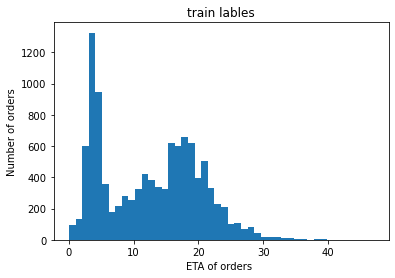

In [71]:
train_label=np.array(train['label']/24)
##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(train_label)))
print("最短时间:%s day"%np.min(train_label))
print("平均时间:%s day"%np.mean(train_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(train_label)),int(max(train_label)),int(max(train_label)))
plt.hist(train_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('train lables')
plt.show()

## 观察下测试集中给了多少天的轨迹数据
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day

最长时间:26.122685185185187 day
最短时间:0.004050925925925926 day
平均时间:2.532971064814815 day


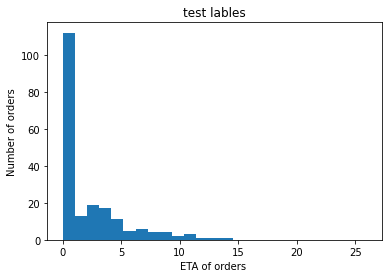

In [72]:
#观察下测试集中给了多少天的轨迹数据
test_label=np.array(test['label']/24)
##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(test_label)))
print("最短时间:%s day"%np.min(test_label))
print("平均时间:%s day"%np.mean(test_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(test_label)),int(max(test_label)),int(max(test_label)))
plt.hist(test_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('test lables')
plt.show()

## 搭建训练模型

## xgb+lgb

In [73]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
#from featexp import get_univariate_plots#用于特征筛选，需要先安装featexp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [74]:
#
features =['k_1_4','k_3_4','k_median','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt']
train_data=train[features]
test_data=test[features]
y=train['label']
train_data.shape,test_data.shape

((10842, 36), (200, 36))

In [75]:
np.mean(test_data['dis']),np.mean(test_data['dis_sqrt']),np.mean(test_data['lon_dis']),np.mean(test_data['lat_dis']),np.mean(test_data['cal_speed']),np.mean(test_data['speed_mean'])

(7844.165809631035,
 97.0799578083976,
 91.25515196500001,
 18.731318885,
 20.60718950450928,
 22.087051927824724)

In [76]:
np.mean(train_data['dis']),np.mean(train_data['dis_sqrt']),np.mean(train_data['lon_dis']),np.mean(train_data['lat_dis']),np.mean(train_data['cal_speed']),np.mean(train_data['speed_mean'])

(7101.583593005861,
 81.06784493329286,
 74.88407026978417,
 22.939516828537172,
 23.420169774774276,
 24.115908892072348)

In [77]:
#features =['k_median','speed_mean','direction_mean','dis','lon_dis','lat_dis','cal_speed','dis_sqrt']
#train_data=train[features]
#test_data=test[features]
#y=train['label']
#train_data.shape,test_data.shape

In [78]:
#featuresx=[ 'dis','lon_dis','lat_dis','cal_speed']
#train_data=train_data[featuresx]
#test_data=test_data[featuresx]

In [79]:
'''
def pre_process(data):
    data=data.apply( lambda x: (x - x.mean()) / (x.std()))
    data=data.fillna(0.)
    return data

train_test=pd.concat((train_data,test_data),axis=0).reset_index(drop=True)
train_test=pre_process(train_test)
train_data=train_test[:train_data.shape[0]].reset_index(drop=True)
test_data=train_test[train_data.shape[0]:].reset_index(drop=True)
'''


'\ndef pre_process(data):\n    data=data.apply( lambda x: (x - x.mean()) / (x.std()))\n    data=data.fillna(0.)\n    return data\n\ntrain_test=pd.concat((train_data,test_data),axis=0).reset_index(drop=True)\ntrain_test=pre_process(train_test)\ntrain_data=train_test[:train_data.shape[0]].reset_index(drop=True)\ntest_data=train_test[train_data.shape[0]:].reset_index(drop=True)\n'

In [80]:
x_train,x_test,y_train,y_test=train_test_split(train_data,y,test_size=0.1,random_state=2020)

In [81]:
x_train.shape,x_test.shape

((9757, 36), (1085, 36))

In [82]:
llf=gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.1,
                        n_estimators=500)

llf.fit(x_train,y_train)

llf_val_mse=mean_squared_error(y_test,llf.predict(x_test))
llf_train_mse=mean_squared_error(y_train,llf.predict(x_train))
print('val_mse:','{:e}'.format(llf_val_mse))
print('train_mse:','{:e}'.format(llf_train_mse))

val_mse: 2.177728e+02
train_mse: 1.579003e+01


In [83]:
#
other_params = {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

xlf = xgb.XGBRegressor(**other_params)
xlf.fit(x_train,y_train)
xlf_val_mse=mean_squared_error(y_test,xlf.predict(x_test))
xlf_train_mse=mean_squared_error(y_train,xlf.predict(x_train))
print('val_mse:','{:e}'.format(xlf_val_mse))
print('train_mse:','{:e}'.format(xlf_train_mse))

val_mse: 2.515409e+02
train_mse: 1.256380e+01


In [84]:
details=[]
answers=np.zeros(len(test))
n_splits=5
cnt=0
mean_error=0
sk=KFold(n_splits=n_splits,shuffle=True,random_state=2020)
for train_k,test_k in sk.split(train_data,y):
    cnt+=1
    x_train=train_data.iloc[train_k]
    y_train=y.iloc[train_k]
    x_test=train_data.iloc[test_k]
    y_test=y.iloc[test_k]
    
    xlf.fit(x_train,y_train)
    pred_xgb=xlf.predict(x_test)
    weight_xgb=mean_squared_error(y_test,pred_xgb)
    
    llf.fit(x_train,y_train)
    pred_llf=llf.predict(x_test)
    weight_lgb=mean_squared_error(y_test,pred_llf)
    
    
    prob_xgb=xlf.predict(x_test)
    prob_lgb=llf.predict(x_test)
    
    errors=[]
    ij=[]
    weight=np.arange(0,1.05,0.1)
    for i,item in enumerate(weight):
        prob_end=prob_xgb*item+prob_lgb*(1-item)
        error=mean_squared_error(y_test,prob_end)
        errors.append(error)
        ij.append((item,1-item))
    
    ii=ij[np.argmin(errors)][0]
    jj=ij[np.argmin(errors)][1]
    
    details.append(min(errors))
    details.append(weight_xgb)
    details.append(weight_lgb)
    details.append(ii)
    details.append(jj)

    print("第%d次验证mse误差为%f" %(cnt,min(errors)))
   
    test_xgb=xlf.predict(test_data)
    test_lgb=llf.predict(test_data)
    ans=test_xgb*ii+test_lgb*jj
    ans=test_lgb
    mean_error+=min(errors)/n_splits
    answers+=ans/n_splits
print("平均验证误差%f"%mean_error)

第1次验证mse误差为214.293933
第2次验证mse误差为213.473831
第3次验证mse误差为245.788997
第4次验证mse误差为191.441494
第5次验证mse误差为346.476270
平均验证误差242.294905


## 观察训练/验证过程

In [85]:
#观察训练/验证过程
df=pd.DataFrame(np.array(details).reshape(int(len(details)/5),5)
                ,columns=['test_end_score','xgboost','lightgbm','weight_xgboost','weight_lightgbm',])
df

,test_end_score,xgboost,lightgbm,weight_xgboost,weight_lightgbm
0,214.293933,242.775065,221.744505,0.3,0.7
1,213.473831,243.528864,227.422803,0.4,0.6
2,245.788997,280.928660,253.622751,0.3,0.7
3,191.441494,209.792792,203.475570,0.4,0.6
4,346.476270,404.654672,348.753245,0.2,0.8


## 观察预测结果的分布

预测的最长时间:34.22255558602563 day
预测的最短时间:0.36308368925485907 day
预测的平均时间:13.658684069627926 day


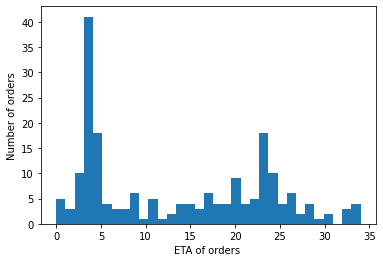

In [86]:
##观察下预测结果的分布
re_day=answers/24
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("预测的最长时间:%s day"%(np.max(re_day)))
print("预测的最短时间:%s day"%np.min(re_day))
print("预测的平均时间:%s day"%np.mean(re_day))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(re_day)),int(max(re_day)),int(max(re_day)))
plt.hist(re_day,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.show()
plt.close()

In [95]:
#
ans1_5k=np.load('../submit/1_5k.npy')
ans_10k=np.load('../submit/ans_10k.npy')
print("answer与ans1_5k的mse:%.0f"%mean_squared_error(answers,ans1_5k))
print("answer与ans_10k的mse:%.0f"%mean_squared_error(answers,ans_10k))
print("ans1_5k与ans_10k的mse:%.0f"%mean_squared_error(ans1_5k,ans_10k))

answer与ans1_5k的mse:6963
answer与ans_10k的mse:7514
ans1_5k与ans_10k的mse:4251


In [96]:
del_index=[5,
30,
31,
41,
50,
58,
131,
134,
144,
150,
153,
154,
156,
157,
164,
165,
172,
179,
192]
ans_10k=np.load('../submit/rxd_pre_6k9.npy')
ans_10k=np.delete(ans_10k, del_index)
np.save('../submit/rxd_6k9.npy',ans_10k)

In [57]:
deltaSub=abs(ans1_5k-answers)
for i in range(len(deltaSub)):
    if deltaSub[i]>200:
        print(deltaSub[i],i)

251.5655858583791 3
250.81585581082243 5
237.2369642572835 66
224.3347031242829 91
250.6704997434813 93
228.55973590753092 99
292.0004513617529 127
209.91981954293246 129
300.51079097248885 133
278.30592640138684 134
315.6826686469656 135
224.6017114997566 174


In [112]:
answers[143],dw4k[143]

(154.19949349357455, 454.2184355555555)

In [111]:
uniq_order=df_test['loadingOrder'].unique()
uniq_order[143]

'JV646262964847'

In [104]:
def tmp_func():
    grouped=df_test.groupby('loadingOrder',sort=False)
    cnt=0
    for name,group in grouped:
        group=group.reset_index(drop=True)
        if group

In [97]:
geodesic((16,67), (16.03,67)).km

3.3197652868830527

In [114]:
df_test[df_test['loadingOrder'].isin(['JV646262964847'])]

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp,start_x,start_y,end_x,end_y
39291,JV646262964847,2020-04-28 00:02:43+00:00,-99.905583,16.499700,33.0,11200.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T00:02:43.000Z,113.863058,22.559462,-61.512151,10.642862
39359,JV646262964847,2020-04-28 00:06:31+00:00,-99.887150,16.492317,33.0,11200.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T00:06:31.000Z,113.863058,22.559462,-61.512151,10.642862
39391,JV646262964847,2020-04-28 00:08:44+00:00,-99.876167,16.487900,33.0,11200.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T00:08:44.000Z,113.863058,22.559462,-61.512151,10.642862
39454,JV646262964847,2020-04-28 00:12:38+00:00,-99.857150,16.480300,34.0,11200.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T00:12:38.000Z,113.863058,22.559462,-61.512151,10.642862
39525,JV646262964847,2020-04-28 00:16:31+00:00,-99.838050,16.472567,33.0,11300.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T00:16:31.000Z,113.863058,22.559462,-61.512151,10.642862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58304,JV646262964847,2020-04-28 23:14:32+00:00,-93.550950,13.133417,32.0,12000.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T23:14:32.000Z,113.863058,22.559462,-61.512151,10.642862
58554,JV646262964847,2020-04-28 23:39:14+00:00,-93.444233,13.073267,32.0,12000.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T23:39:14.000Z,113.863058,22.559462,-61.512151,10.642862
58591,JV646262964847,2020-04-28 23:41:38+00:00,-93.433967,13.067400,32.0,12000.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T23:41:38.000Z,113.863058,22.559462,-61.512151,10.642862
58688,JV646262964847,2020-04-28 23:54:13+00:00,-93.379583,13.036633,32.0,11900.0,RWHZVZ,V9073335880,2020-04-28 00:02:43,CNSHK-HKHKG-TWKHH-CNNBG-CNSHA-CNTAO-KRPUS-MXZL...,2020-04-28T23:54:13.000Z,113.863058,22.559462,-61.512151,10.642862


## 特征重要度筛选

<Figure size 1296x648 with 0 Axes>

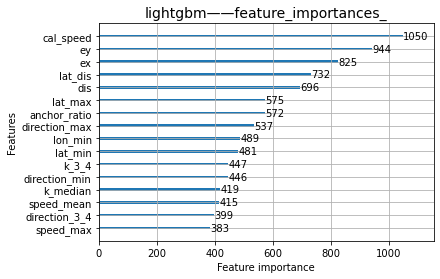

In [58]:
plt.figure(figsize=(18,9))
lgb.plot_importance(llf,max_num_features=16)
plt.title('lightgbm——feature_importances_',fontsize=14)
plt.show()

<Figure size 1296x648 with 0 Axes>

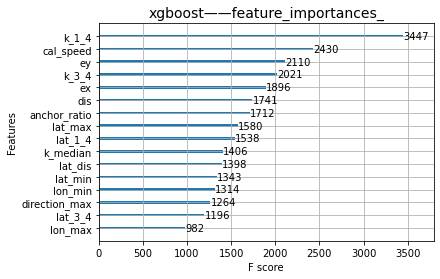

In [59]:
plt.figure(figsize=(18,9))
xgb.plot_importance(xlf,max_num_features=16,importance_type='weight')#'gain'可以换成weight
plt.title('xgboost——feature_importances_',fontsize=14)
plt.show()

Text(0.5, 1.0, 'xgboost&lightgbm——feature_importances_')

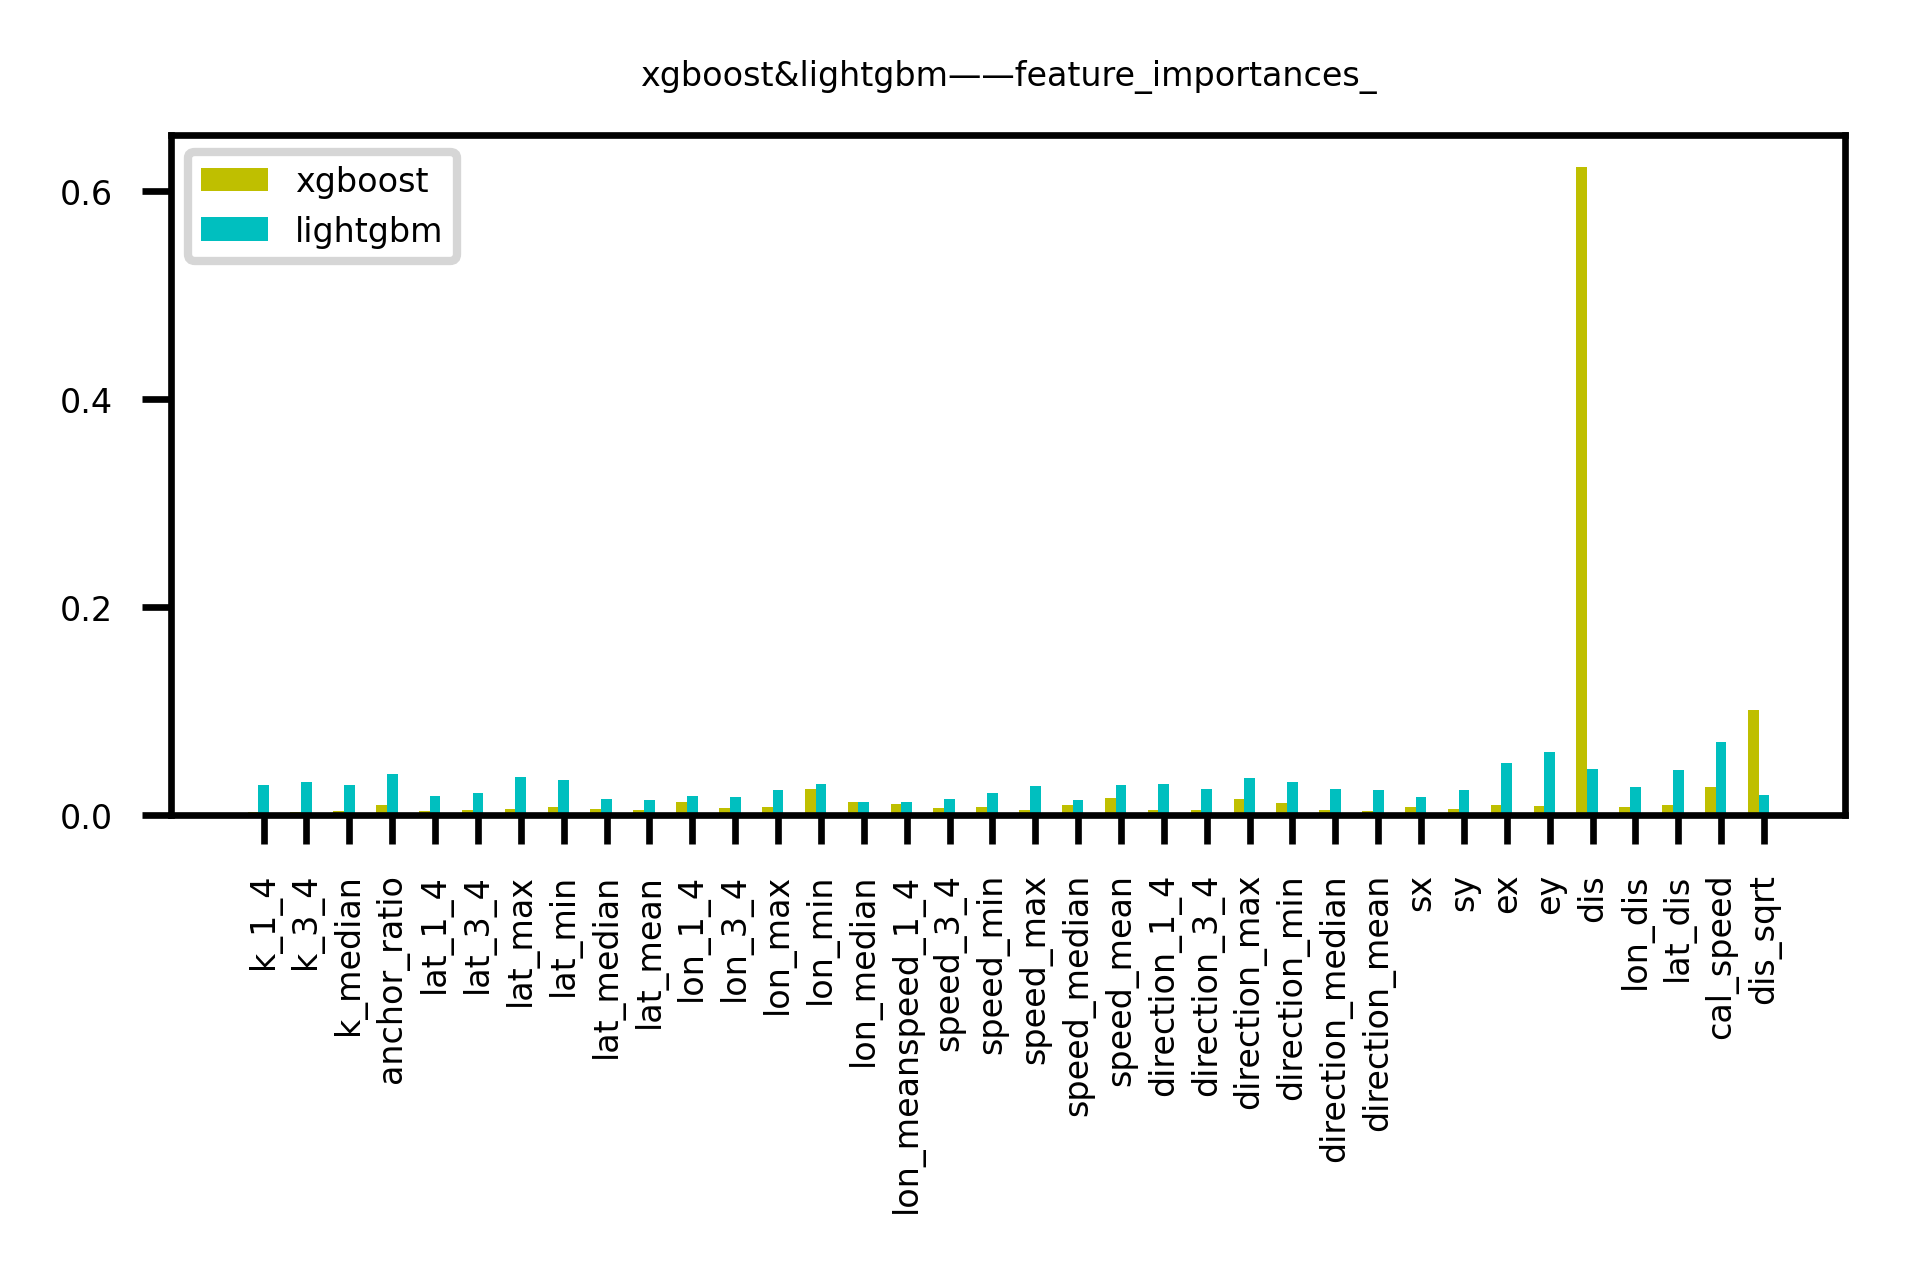

In [88]:
width=0.25
address=np.arange(len(train_data.columns))
tick_label=train_data.columns
plt.figure(dpi=600,figsize=(3.6,1.5))
plt.bar(address
        ,xlf.feature_importances_
        ,width
        ,color='y'
        ,label='xgboost')
plt.bar(address+width
        ,llf.feature_importances_/sum(llf.feature_importances_)
        ,width
        ,color='c'
        ,label='lightgbm')
plt.legend(fontsize=4)
plt.xticks(address+width
           ,tick_label
           ,fontsize=4
           ,rotation=90
           ,horizontalalignment='center')
plt.yticks(fontsize=4,rotation=0)
plt.title('xgboost&lightgbm——feature_importances_',fontsize=4)

## 生成提交文件

DH829189593918 105.0
24 105.0
LE381377964668 68.0
87,68.0

In [90]:
test['label'] = answers
result=test[['loadingOrder', 'label']]
test_data_path = '../R2 ATest 0711.csv'
test_data=pd.read_csv(test_data_path)
test_data=get_data(test_data, mode='test')
#
test_data = test_data.merge(result, on='loadingOrder', how='left')
test_data['ETA'] = (test_data['onboardDate'] + test_data['label'].apply(lambda x:pd.Timedelta(hours=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data.drop(['direction','TRANSPORT_TRACE'],axis=1,inplace=True)
test_data['onboardDate'] = test_data['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
test_data['timestamp'] = test_data['temp_timestamp']
# 整理columns顺序
submit = test_data[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

In [122]:
submit[submit['loadingOrder'].isin(['FA712454830300'])]

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
29536,FA712454830300,2020-01-28T05:19:28.000Z,114.061383,22.359500,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
29537,FA712454830300,2020-01-28T05:24:28.000Z,114.074933,22.350750,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
29538,FA712454830300,2020-01-28T05:29:58.000Z,114.081983,22.329350,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
29541,FA712454830300,2020-01-28T05:30:28.000Z,114.082833,22.327083,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
29544,FA712454830300,2020-01-28T05:31:28.000Z,114.084383,22.323150,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
...,...,...,...,...,...,...,...,...,...
32945,FA712454830300,2020-02-23T07:41:08.000Z,31.126853,-29.817860,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
32946,FA712454830300,2020-02-23T07:43:08.000Z,31.125547,-29.818770,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
32947,FA712454830300,2020-02-23T07:46:08.000Z,31.119920,-29.818930,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14
32948,FA712454830300,2020-02-23T07:47:08.000Z,31.118000,-29.818530,RWHZVZ,D2070531050,2020/01/28 04:52:18,2020/02/08 15:04:30,2020/07/21 18:39:14


In [130]:
submit.to_csv('../submit/716subv2.csv', index=False)

In [131]:
np.save('../submit/716subv2.npy',answers)